<a href="https://www.kaggle.com/code/nishantpatel54/30day-stock-forecast-lstm?scriptVersionId=146077852" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.0/928.0 kB 17.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for peewee: filename=peewee-3.16.3-cp310-cp310-linux_x86_64.whl size=314460 sha256=da1022fb3c0ca95646c04e1031c77ab742b9c573bf3eb5e03e184bc5407d487d
  Stored in directory: /root/.cache/pip/wheels/c8/ac/6d/ad6d828725ffbe3abc508c95d25dd0c5fcc63539ae47913790
Successfully built peewee


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

ticker = 'AAPL'
lookback = 60
forecast = 30
end_train='2022-08-02'
start_val='2022-08-03'
#account for 3 years of trading days.
trading_day = 252
days_in_year = 365
period = 4
history = int((365*period)+((365-252)*period))

start_train = datetime.datetime.strptime(end_train, '%Y-%m-%d').date() - datetime.timedelta(days = history)
start_train = start_train.strftime("%Y-%m-%d")

dataset = yf.download(ticker, start=start_train, end=end_train)

dataset_val = yf.download(ticker, start_val)

train_set = dataset[['Close']].fillna(method='ffill')
train_set = train_set.values.reshape(-1,1)

val_set = dataset_val[['Close']].fillna(method='ffill').head(lookback+forecast)
val_set = val_set.values.reshape(-1,1)

train_set.shape, val_set.shape, start_train

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


((1318, 1), (90, 1), '2017-05-08')

In [3]:
sc = MinMaxScaler(feature_range=(0,1))
sc = sc.fit(train_set)
train_set_scaled = sc.transform(train_set)

sc_val = MinMaxScaler(feature_range=(0,1))
sc_val = sc_val.fit(val_set)
val_set_scaled = sc_val.transform(val_set)
val_set_scaled[:10], train_set_scaled[:10]

(array([[0.78780251],
        [0.77973781],
        [0.76814528],
        [0.75604824],
        [0.75730839],
        [0.86617952],
        [0.84727832],
        [0.93825614],
        [0.9657258 ],
        [0.96169345]]),
 array([[0.01846888],
        [0.02014168],
        [0.01889561],
        [0.02007339],
        [0.02374329],
        [0.0230605 ],
        [0.02266792],
        [0.01375778],
        [0.01766662],
        [0.01855423]]))

In [4]:
X_train=[]
y_train=[]
X_val=[]
y_val=[]

for i in range(lookback, len(train_set_scaled) - forecast + 1):
    X_train.append(train_set_scaled[i - lookback : i])
    y_train.append(train_set_scaled[i : i + forecast])

for i in range(lookback, len(val_set_scaled) - forecast + 1):
    X_val.append(val_set_scaled[i - lookback : i])
    y_val.append(val_set_scaled[i : i + forecast])
    
X_train=np.array(X_train)
y_train=np.array(y_train)
X_val=np.array(X_val)
y_val = np.array(y_val)


In [5]:
#model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(forecast))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 50)            2

In [6]:
#train

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/100
39/39 [==============================] - 16s 184ms/step - loss: 0.0851 - val_loss: 0.0443
Epoch 2/100
39/39 [==============================] - 5s 126ms/step - loss: 0.0183 - val_loss: 0.0285
Epoch 3/100
39/39 [==============================] - 5s 125ms/step - loss: 0.0148 - val_loss: 0.0176
Epoch 4/100
39/39 [==============================] - 5s 126ms/step - loss: 0.0126 - val_loss: 0.0157
Epoch 5/100
39/39 [==============================] - 5s 124ms/step - loss: 0.0106 - val_loss: 0.0160
Epoch 6/100
39/39 [==============================] - 5s 127ms/step - loss: 0.0096 - val_loss: 0.0160
Epoch 7/100
39/39 [==============================] - 5s 131ms/step - loss: 0.0094 - val_loss: 0.0156
Epoch 8/100
39/39 [==============================] - 5s 127ms/step - loss: 0.0090 - val_loss: 0.0161
Epoch 9/100
39/39 [==============================] - 5s 124ms/step - loss: 0.0079 - val_loss: 0.0189
Epoch 10/100
39/39 [==============================] - 5s 128ms/step - loss: 0.0071 - val_l

1/1 [==============================] - 2s 2s/step


/tmp/ipykernel_20/848138148.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_past['Forecast'].iloc[-1] = dataset_past['Actual'].iloc[-1]


,Close,Forecast
Date,,
2022-08-01,161.509995,161.509995
2022-08-03,166.130005,153.155319
2022-08-04,165.809998,153.507919
2022-08-05,165.350006,153.025803
2022-08-08,164.869995,153.799225
2022-08-09,164.919998,153.257858
2022-08-10,169.240005,153.598923
2022-08-11,168.490005,153.213776
2022-08-12,172.100006,153.508423


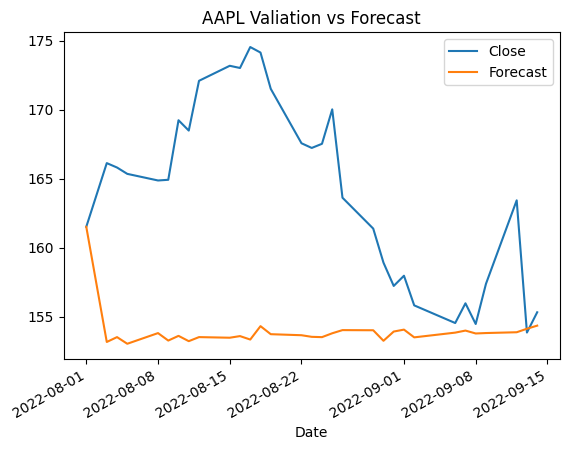

In [7]:
X_ = train_set_scaled[-lookback:]
X_ = X_.reshape(1, lookback, 1)

y_ = model.predict(X_).reshape(-1,1)
y_ = sc.inverse_transform(y_)

dataset_past = dataset[['Close']].reset_index()
dataset_past.rename(columns={'index':'Date','Close':'Actual'},inplace=True)
dataset_past['Date'] = pd.to_datetime(dataset_past['Date'])
dataset_past['Forecast'] = np.nan
dataset_past['Forecast'].iloc[-1] = dataset_past['Actual'].iloc[-1]


dataset_future = dataset_val[['Close']].reset_index()
dataset_future = dataset_future.head(forecast)
dataset_future.rename(columns={'index':'Date','Close':'Validation'})
dataset_future['Date'] = pd.to_datetime(dataset_future['Date'])
dataset_future['Forecast'] = y_.flatten()
dataset_future.set_index('Date', inplace=True)

data=[]
insert_first = {'Date':dataset_past['Date'].iloc[-1], 'Close':dataset_past['Actual'].iloc[-1], 'Forecast':dataset_past['Actual'].iloc[-1]}
data.insert(0,insert_first)
data=pd.DataFrame(data)
data.set_index('Date', inplace=True)
dataset_future = pd.concat([data, dataset_future])


dataset_future.plot(title=ticker + " Valiation vs Forecast")
dataset_future